In [168]:
import pandas as pd
import numpy as np
import pickle
from numpy.random import RandomState
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import lightgbm as ltb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Read CSV
data_source = r"./src/vehicle_data/bat_training_data.csv"
df = pd.read_csv(data_source)

print(f'Data ingested -- Found {len(df)} Rows')

Data ingested -- Found 69873 Rows


In [169]:
target_feature = "Final Bid Price"
df = df.replace(True, 1)
df = df.replace(False, 0)


# Remove vehicles that never sold as it is confusing the model
# Remove manual_trans_bool as it is confusing the model
# Remove carfax_bool
# df = df.drop("Sale_Status", axis=1)
df = df[df.Sale_Status == 1]
df = df.drop("Sale_Status", axis=1)
df = df.drop("manual_trans_bool", axis=1)
df = df.drop("carfax_bool", axis=1)
df = df.drop("auction_day", axis=1)

# Turn everything lowercase
df['Make'] = df['Make'].str.lower()
df['Model'] = df['Model'].str.lower()

# Remove 'erasXXXX' or 'origin' in Makes as they are useless
make_rem_lst = list(set([make for make in df.Make if 'era1' in make or 'era2' in make or 'origin' in make]))
df = df[~df.Make.isin(make_rem_lst)]

# Remove 'erasXXXX' or 'origin' in Makes as they are useless
model_rem_lst = list(set([model for model in df.Model if 'era1' in model or 'era2' in model or 'origin' in model]))
df = df[~df.Model.isin(model_rem_lst)]

df.head()


,Make,Model,Miles,Final Bid Price,paint_str,auction_year,auction_month,adj_model_year
5,acura,integra,52000.0,26500.0,green,2022,11,1997.0
10,acura,integra,72000.0,7100.0,black,2022,10,1995.0
11,acura,integra,43000.0,8900.0,white,2022,9,1995.0
12,acura,integra,47000.0,11800.0,None,2022,8,1994.0
13,acura,integra,35000.0,15500.0,silver,2022,8,2000.0


In [170]:
# print(df.Model.unique())

df.shape

(53448, 8)

In [172]:
# Check for nan values
print('Before:\n', df.isna().sum())

# Convert any nan paint colors to None
df.paint_str = df.paint_str.fillna("None")

# Drop any leftover nans
df = df.dropna()
print(df.Make.nunique())

# Check nan values again
print('\nAfter:\n', df.isna().sum())


df = df[df.Make == 'honda']

y = df[target_feature]
X = df.drop(target_feature, axis=1)
X.head()

Before:
 Make               0
Model              0
Miles              0
Final Bid Price    0
paint_str          0
auction_year       0
auction_month      0
adj_model_year     0
dtype: int64
78

After:
 Make               0
Model              0
Miles              0
Final Bid Price    0
paint_str          0
auction_year       0
auction_month      0
adj_model_year     0
dtype: int64


,Make,Model,Miles,paint_str,auction_year,auction_month,adj_model_year
30635,honda,accord,18000.0,gold,2022,9,1989.0
30636,honda,accord,62000.0,blue,2022,8,1977.0
30638,honda,accord,68000.0,white,2022,4,1991.0
30639,honda,accord,102000.0,beige,2022,4,1987.0
30640,honda,accord,98000.0,brown,2022,3,1992.0


<AxesSubplot:>

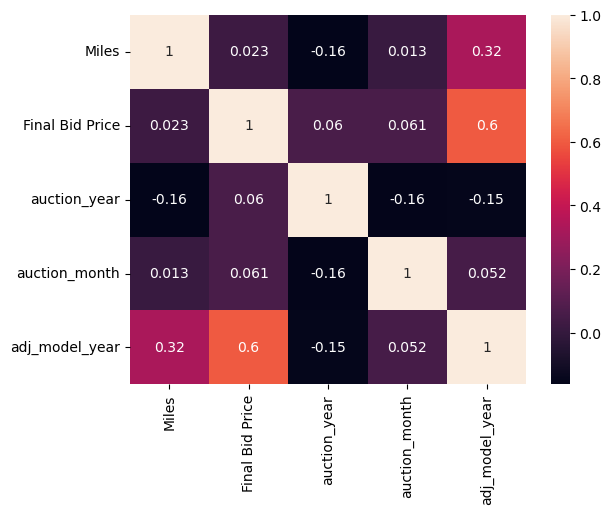

In [173]:
# sns.set(rc={"figure.figsize":(9, 9)})
sns.heatmap(df.corr(), annot = True)

In [174]:
## Find Numerical & Categorical Columns
# Get numerical and categorical feature columns
print('\nCalculating Numerical and Categorical Features...')
print(f'There are {len(X.columns)} total columns.')

numerical_features = X.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features.')

categorical_features = X.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features.', '\n')

print(X.columns)

## Pre-Process Data

print('Fetching Preprocessing Pipeline...\n')

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)


# Try this
# X_train_num = pd.DataFrame(numeric_pipeline.fit_transform(X_train[numerical_features]))
# X_train_num.columns = numeric_pipeline.get_feature_names_out()
# X_train_cat = pd.DataFrame(categorical_pipeline.fit_transform(X_train[categorical_features]))
# X_train_cat.columns = categorical_pipeline.get_feature_names_out()
# # X_train_merged = pd.concat([X_train_num, X_train_cat], ignore_index=True)
# X_train_merged = pd.concat([X_train_num, X_train_cat], axis=1)

# print(X_train_merged.head())

# print(X_train_num)


X_train_transformed = full_processor.fit_transform(X_train)
# X_valid_transformed = full_processor.transform(X_valid)

model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, verbosity=1)
# model = ltb.LGBMClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=1,
#                             early_stopping_rounds=10, eval_set=[(X_valid_transformed, y_valid)])


model_pipeline = Pipeline(steps=[
        ('preprocessor', full_processor),
        ('model', model)
    ])

# fit_params = {"model__eval_set": [(X_valid_transformed, y_valid)], 
#               "model__early_stopping_rounds": 5,
#               "model__verbosity": 0}

# model.set_params(**fit_params)


Calculating Numerical and Categorical Features...
There are 7 total columns.
There are 4 numerical features.
There are 3 categorical features. 

Index(['Make', 'Model', 'Miles', 'paint_str', 'auction_year', 'auction_month',
       'adj_model_year'],
      dtype='object')
Fetching Preprocessing Pipeline...



In [175]:
print(len(X_train), len(y_train))

1592 1592


In [176]:
# print(len(X_train), len(y_train))
# Preprocessing of training data, fit model 
# model_pipeline.fit(X_train, y_train, **fit_params)
hist = model_pipeline.fit(X_train, y_train)#, model__eval_metric=['mse'], model__eval_set=[(X_train, y_train), (X_valid_transformed, y_valid)], 
            #model__early_stopping_rounds=20)

In [177]:
# Preprocessing of validation data, get predictions
preds = model_pipeline.predict(X_valid)

# Evaluate the model
print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 4157.37601766155


In [178]:
# hist.get_booster().get_score(importance_type='gain')
hist.named_steps['model'].get_booster().get_score(importance_type='weight')

{'f0': 1315.0,
 'f1': 455.0,
 'f2': 473.0,
 'f3': 610.0,
 'f5': 14.0,
 'f6': 7.0,
 'f8': 9.0,
 'f9': 15.0,
 'f10': 44.0,
 'f11': 34.0,
 'f12': 4.0,
 'f14': 73.0,
 'f15': 12.0,
 'f16': 28.0,
 'f17': 74.0,
 'f18': 26.0,
 'f19': 8.0,
 'f20': 38.0,
 'f21': 2.0,
 'f22': 71.0,
 'f23': 56.0,
 'f24': 14.0,
 'f25': 7.0,
 'f26': 20.0,
 'f27': 14.0,
 'f28': 17.0,
 'f29': 2.0,
 'f30': 75.0,
 'f31': 61.0,
 'f32': 80.0,
 'f33': 53.0}

## Testing Predictions

In [179]:
# X_valid[X_valid["Make"] == "Subaru"]
# X_valid.loc[[63667]]
# # X_valid.loc[[63607]]
# # y_valid.loc[[63667]]

In [180]:
tst_data = ["subaru", "wrx sti", 55000, "blue", 2022, 5, 2004]
columns = ['Make', 'Model', 'Miles', 'paint_str', 'auction_year', 'auction_month', 'adj_model_year']
tst = pd.DataFrame()
for idx, col in enumerate(columns):
    tst[col] = pd.Series(tst_data[idx])
preds = model_pipeline.predict(tst)
preds

array([17350.812], dtype=float32)

In [1]:
# X_processed = full_processor.fit_transform(X)
# print(X_processed)

## Train/Test Split

# X_train, X_valid, y_train, y_valid = train_test_split(X_processed, y, test_size=0.30, random_state=42)

## LightGBM Model Pipeline

# print('Creating LightGBM Model...\n')

# # Run model without params to perform grid search
# if do_grid_search:
#     model = ltb.LGBMClassifier(seed=42, verbose=1)

# # Run model with specified params
# else: 
#     # model = ltb.LGBMClassifier(seed=42, verbose=1, n_estimators = n_estimators, learning_rate = lr, max_depth = max_depth)
#     model = ltb.LGBMClassifier(random_state=42, n_estimators=n_estimators, num_leaves=64, max_depth=5, learning_rate=lr, n_jobs=-1)

# # Create model pipeline including preprocessor
# ltb_pipeline = Pipeline(steps=[
#     # ('preprocess', preprocessor),
#     ('model', model)
# ])

# print('Fitting XGBoost Model...\n')
# return ltb_pipeline

## Grid Search

# model = ltb.LGBMClassifier(seed=42, verbosity=2)

# param_dict = {
#     'model__learning_rate': [0.01, 1, 0.1],
#     'model__max_depth': range (1, 5, 1),
#     'model__n_estimators': range(60, 200, 40),
#     'model__early_stopping_rounds' : [30]
# }

# print('Starting Grid Search...\n')
# search = GridSearchCV(model, param_dict, 
#                   cv=3, 
#                   scoring='neg_mean_absolute_error',
#                   verbose=3)

# search.fit(X_train, y_train)

# print('Best score:', abs(search.best_score_))

# print('Best params:', search.best_params_)

# print('Best estimator:', search.best_estimator_)

# return search.best_params_.values()

## Training

# # Create and fit model
# lgb_model = ltb.LGBMClassifier(random_state=42, n_estimators=100, num_leaves=64, max_depth=5, learning_rate=0.1, n_jobs=-1, verbosity=3)
# improved_model = lgb_model.fit(X_train, y_train) 

# # Get predictions and output results
# preds = improved_model.predict(X_valid)
# MAE = mean_absolute_error(y_valid, preds)
# r2 = improved_model.score(X_valid, y_valid)
# print('MAE:', MAE)
# print('R2:', r2)

# # Create and fit model
# xgbr = XGBRegressor(seed=42, max_depth=3, learning_rate=0.1, verbosity=3)
# improved_model = xgbr.fit(X_train, y_train) 

# # Get predictions and output results
# preds = improved_model.predict(X_valid)
# MAE = mean_absolute_error(y_valid, preds)
# r2 = improved_model.score(X_valid, y_valid)
# print('MAE:', MAE)
# print('R2:', r2)

KeyboardInterrupt: 